In [16]:
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib as plt
import math

In [17]:
movements = pd.read_csv('../data/data_movements_10.csv')
trials = pd.read_csv('../data/data_trials_10.csv')
trials['trial'] = trials.trial - 1

In [18]:
df = movements[['x', 'y', 'time', 'trial', 'state']]

# Desired timestamp granularity
timestamp_granularity = 0.001

# Create an empty list to store interpolated dataframes
interpolated_dfs = []

# Iterate through the rows of the original DataFrame
for i in range(len(df) - 1):
    # Extract data from the current and next rows
    current_row = df.iloc[i]
    next_row = df.iloc[i + 1]

    # Calculate the time points for interpolation
    t1 = current_row["time"]
    t2 = next_row["time"]

    # Calculate the number of points to interpolate between t1 and t2
    num_points = int((t2 - t1) / timestamp_granularity)

    # Create an array of interpolated time points
    interpolated_times = np.linspace(t1, t2, num_points + 1)

    # Perform linear interpolation for 'x' and 'y' columns
    interpolated_x = np.interp(interpolated_times, [t1, t2], [current_row["x"], next_row["x"]])
    interpolated_y = np.interp(interpolated_times, [t1, t2], [current_row["y"], next_row["y"]])

    # Create a new DataFrame for this segment of interpolation
    interpolated_segment = pd.DataFrame({
        "x": interpolated_x,
        "y": interpolated_y,
        "time": interpolated_times,
        "trial": [current_row["trial"]] * (num_points + 1),  # Include trial number
        "state": [current_row["state"]] * (num_points + 1)  # Include state
    })

    # Append the interpolated segment to the list
    interpolated_dfs.append(interpolated_segment)

# Concatenate all interpolated segments into one DataFrame
interpolated_df = pd.concat(interpolated_dfs, ignore_index=True)

# Print the interpolated DataFrame
interpolated_df


,x,y,time,trial,state
0,1.121942,2.483705,0.008520,0,search_ring
1,1.121942,2.483708,0.009546,0,search_ring
2,1.121942,2.483711,0.010572,0,search_ring
3,1.121942,2.483714,0.011598,0,search_ring
4,1.121942,2.483716,0.012624,0,search_ring
...,...,...,...,...,...
1854953,-2.377360,19.344921,1805.180097,299,iti
1854954,-2.377353,19.344924,1805.181154,299,iti
1854955,-2.377346,19.344928,1805.182212,299,iti
1854956,-2.377339,19.344931,1805.183270,299,iti


<Axes: xlabel='x', ylabel='y'>

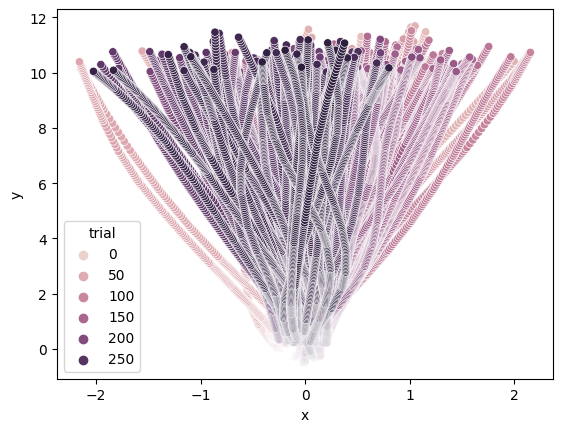

In [19]:
sns.scatterplot(data = interpolated_df.loc[interpolated_df.state == 'reach'], x = 'x', y = 'y', hue = 'trial')

In [20]:
# velocity is the change in distance over the change in time

def euclid_dist(x1, x2, y1, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)


change_in_dist= [0]
for i in range(1, len(interpolated_df)):
    current_row = interpolated_df.iloc[i]
    previous_row = interpolated_df.iloc[i-1]
    change_in_dist.append(euclid_dist(previous_row.x, current_row.x, previous_row.y, current_row.y))

interpolated_df['change_in_dist'] = change_in_dist



In [21]:
# velocity is the change in distance over the change in time
velocity = interpolated_df.change_in_dist/0.001
interpolated_df['velocity'] = velocity

In [22]:
max_vel_df = interpolated_df.loc[interpolated_df.state == 'reach'].groupby('trial').agg({'velocity': 'max'}).reset_index()
max_vel_df = max_vel_df.rename(columns={'velocity': 'max_vel'})
max_vel_df

,trial,max_vel
0,0,79.799353
1,1,79.011948
2,2,84.594958
3,3,95.934358
4,4,68.582050
...,...,...
295,295,72.047682
296,296,67.212499
297,297,66.556080
298,298,106.424530


In [23]:
joined = pd.merge(interpolated_df, max_vel_df, on = 'trial', how = 'left')

In [24]:
initial_vector = joined.loc[(joined.state == 'reach') & (joined.velocity == joined.max_vel)].copy()
min_time = initial_vector.groupby('trial').agg({'time':'min'}).reset_index().rename(columns={'time': 'min_time'})
initial_vector = pd.merge(initial_vector, min_time, on='trial', how='left')
initial_vector = initial_vector.loc[initial_vector.time == initial_vector.min_time]
initial_vector

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time
0,-0.232176,6.866197,6.367825,0,reach,0.079799,79.799353,79.799353,6.367825
8,-0.179310,6.367210,11.501927,1,reach,0.079012,79.011948,79.011948,11.501927
9,-0.088458,6.862073,17.286092,2,reach,0.084595,84.594958,84.594958,17.286092
14,-0.267606,6.201363,22.109600,3,reach,0.095934,95.934358,95.934358,22.109600
15,-0.154475,5.472871,27.201159,4,reach,0.068582,68.582050,68.582050,27.201159
...,...,...,...,...,...,...,...,...,...
1553,0.160600,5.709158,1782.386274,295,reach,0.072048,72.047682,72.047682,1782.386274
1558,0.255726,5.456006,1787.235192,296,reach,0.067212,67.212499,67.212499,1787.235192
1567,-0.365153,8.648769,1792.651403,297,reach,0.066556,66.556080,66.556080,1792.651403
1577,0.227912,9.268282,1797.751429,298,reach,0.106425,106.424530,106.424530,1797.751429


In [25]:
# convert x, y coordinates for 'reach' to polar and add these to the data as columns 
# function inspired from https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates 
def cart2pol(x, y):
    r = []
    theta = []
    for i in range(len(x)): 
        r.append(np.sqrt((x[i])**2 + (y[i])**2))
        theta.append(np.arctan2(y[i], x[i]))
    return(r, theta)


reach_x = initial_vector.x.values
reach_y  = initial_vector.y.values

r, theta = cart2pol(reach_x, reach_y)

initial_vector['r'] = r 
initial_vector['theta'] = theta

In [26]:
initial_vector

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time,r,theta
0,-0.232176,6.866197,6.367825,0,reach,0.079799,79.799353,79.799353,6.367825,6.870121,1.604598
8,-0.179310,6.367210,11.501927,1,reach,0.079012,79.011948,79.011948,11.501927,6.369734,1.598950
9,-0.088458,6.862073,17.286092,2,reach,0.084595,84.594958,84.594958,17.286092,6.862643,1.583687
14,-0.267606,6.201363,22.109600,3,reach,0.095934,95.934358,95.934358,22.109600,6.207134,1.613922
15,-0.154475,5.472871,27.201159,4,reach,0.068582,68.582050,68.582050,27.201159,5.475050,1.599014
...,...,...,...,...,...,...,...,...,...,...,...
1553,0.160600,5.709158,1782.386274,295,reach,0.072048,72.047682,72.047682,1782.386274,5.711417,1.542674
1558,0.255726,5.456006,1787.235192,296,reach,0.067212,67.212499,67.212499,1787.235192,5.461995,1.523960
1567,-0.365153,8.648769,1792.651403,297,reach,0.066556,66.556080,66.556080,1792.651403,8.656474,1.612991
1577,0.227912,9.268282,1797.751429,298,reach,0.106425,106.424530,106.424530,1797.751429,9.271083,1.546211


In [27]:
plot_data = pd.merge(initial_vector, trials, on = 'trial', how = 'left')

In [28]:
previous_uncertainty = ['baseline_no_uncertainty'] * 21
columns_to_iterate = ['cursor_vis', 'no_uncertainty', 'low_uncertainty', 'high_uncertainty', 'unlimited_uncertainty']

for i in range(21, len(plot_data) - 99):
    prev_row = plot_data.iloc[i - 1]
    if prev_row.no_uncertainty == True:
        previous_uncertainty.append('no_uncertainty')
    elif prev_row.low_uncertainty == True: 
        previous_uncertainty.append('low_uncertainty')
    elif prev_row.high_uncertainty == True: 
        previous_uncertainty.append('high_uncertainty')
    elif prev_row.unlimited_uncertainty == True: 
        previous_uncertainty.append('unlimited_uncertainty')
    else: 
        previous_uncertainty.append('unlimited_uncertainty')

previous_uncertainty += ['washout_unlimited_uncertainty'] * (300 - len(previous_uncertainty))
plot_data['previous_uncertainty'] = previous_uncertainty

In [29]:
plot_data

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time,r,...,cycle,target_angle,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,endpoint_theta,movement_time,movement_initiation_time,previous_uncertainty
0,-0.232176,6.866197,6.367825,0,reach,0.079799,79.799353,79.799353,6.367825,6.870121,...,0,90,0.0,0.0,0.0,0.0,89.925900,0.168894,0.734254,baseline_no_uncertainty
1,-0.179310,6.367210,11.501927,1,reach,0.079012,79.011948,79.011948,11.501927,6.369734,...,1,90,0.0,0.0,0.0,0.0,90.931319,0.199896,0.882275,baseline_no_uncertainty
2,-0.088458,6.862073,17.286092,2,reach,0.084595,84.594958,84.594958,17.286092,6.862643,...,2,90,0.0,0.0,0.0,0.0,89.790176,0.182896,0.716274,baseline_no_uncertainty
3,-0.267606,6.201363,22.109600,3,reach,0.095934,95.934358,95.934358,22.109600,6.207134,...,3,90,0.0,0.0,0.0,0.0,93.807569,0.164953,0.635223,baseline_no_uncertainty
4,-0.154475,5.472871,27.201159,4,reach,0.068582,68.582050,68.582050,27.201159,5.475050,...,4,90,0.0,0.0,0.0,0.0,92.226969,0.366950,0.833228,baseline_no_uncertainty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.160600,5.709158,1782.386274,295,reach,0.072048,72.047682,72.047682,1782.386274,5.711417,...,295,90,0.0,0.0,0.0,0.0,88.887198,0.198774,0.602355,washout_unlimited_uncertainty
296,0.255726,5.456006,1787.235192,296,reach,0.067212,67.212499,67.212499,1787.235192,5.461995,...,296,90,0.0,0.0,0.0,0.0,90.202478,0.216794,0.500241,washout_unlimited_uncertainty
297,-0.365153,8.648769,1792.651403,297,reach,0.066556,66.556080,66.556080,1792.651403,8.656474,...,297,90,0.0,0.0,0.0,0.0,92.267049,0.232816,0.550214,washout_unlimited_uncertainty
298,0.227912,9.268282,1797.751429,298,reach,0.106425,106.424530,106.424530,1797.751429,9.271083,...,298,90,0.0,0.0,0.0,0.0,88.051702,0.150755,0.584249,washout_unlimited_uncertainty


<Axes: xlabel='trial', ylabel='theta'>

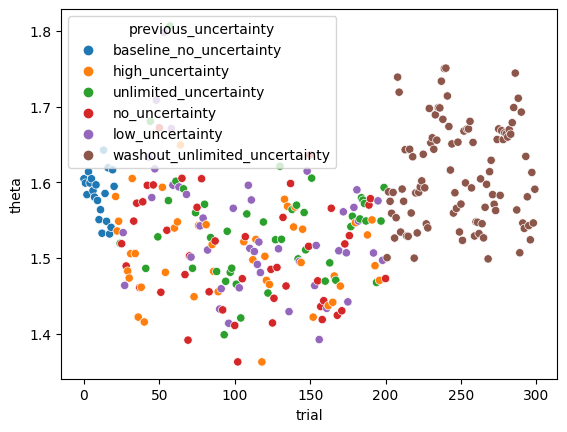

In [34]:
sns.scatterplot(data = plot_data, x = 'trial', y = 'theta', hue = 'previous_uncertainty')